In [1]:
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt

# 截断问题分析

## 工作路径

In [4]:
DATASET_BASE = '/home/LAB/wangd/graduation_project/ranked list truncation/dataset/robust04'

## 所用指标是否关于k构成可优化的问题

In [5]:
# 导入ground truth
with open('{}/gt.pkl'.format(DATASET_BASE), 'rb') as f:
    gt = pickle.load(f)
    for key in gt: gt[key] = set(gt[key])

def cal_F1(ranked_list: list, k: int) -> float:
    """
    计算F1 score
    k: 截断到第k个，从1计数
    """
    count, N_D = sum(ranked_list[:k]), sum(ranked_list)
    p_k = count / k
    r_k = (count / N_D) if N_D != 0 else 0
    return (2 * p_k * r_k / (p_k + r_k)) if p_k + r_k != 0 else 0

def cal_DCG(ranked_list: list, k: int, penalty=-1) -> float:
    """
    计算DCG
    """
    value = 0
    for i in range(k): 
        value += (1 / math.log(i + 2, 2)) if ranked_list[i] else (penalty / math.log(i + 2, 2))
    return value

def dataset_prepare(dataset_name: str) -> list:
    # 这里不需要train
    with open('{}/{}_train.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
        train_data = pickle.load(f)
    train_rl = {}
    for key in train_data: 
        train_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, train_data[key].keys()))
    return train_rl

def greedy_scores(dataset_name: str) -> float:
    train_set = dataset_prepare(dataset_name)
    F1_k, DCG_k = [], []
    for key in train_set:
        per_k_F1, per_k_DCG = [0], [0]
        for i in range(1, 301):
            per_k_F1.append(cal_F1(train_set[key], i))
            per_k_DCG.append(cal_DCG(train_set[key], i))
        F1_k.append(per_k_F1)
        DCG_k.append(per_k_DCG)
    
    F1_k_mean, DCG_k_mean = np.mean(np.array(F1_k), axis=0), np.mean(np.array(DCG_k), axis=0)
    return F1_k_mean, DCG_k_mean

In [6]:
f1_bm25, dcg_bm25 = greedy_scores('bm25')
f1_drmm, dcg_drmm = greedy_scores('drmm')
f1_drmm_tks, dcg_drmm_tks = greedy_scores('drmm_tks')

<Figure size 1152x504 with 0 Axes>

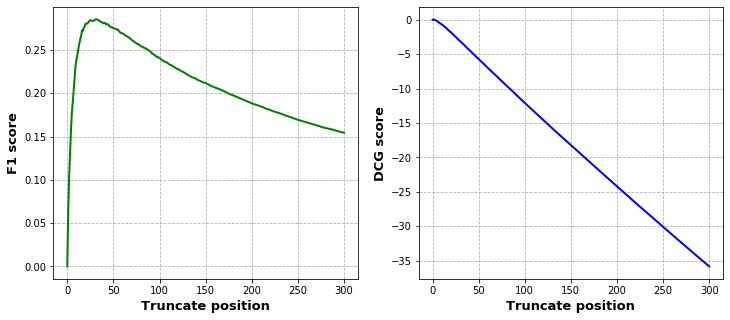

In [41]:
plt.figure(figsize=(16, 7))
x = np.arange(301)


plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.grid(linestyle = "--")
plt.plot(x, f1_bm25, color="green",linewidth=2.)
plt.xlabel('Truncate position', fontsize=13,fontweight='bold')
plt.ylabel('F1 score', fontsize=13,fontweight='bold')

plt.subplot(1, 2, 2)
plt.grid(linestyle = "--")
plt.plot(x, dcg_bm25, color="blue",linewidth=2.)
plt.xlabel('Truncate position', fontsize=13,fontweight='bold')
plt.ylabel('DCG score', fontsize=13,fontweight='bold')

plt.show()

Text(0, 0.5, 'DCG score')

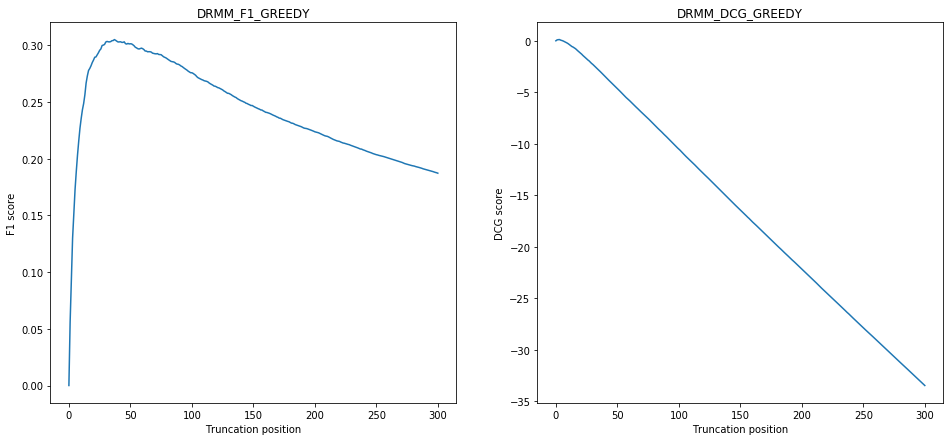

In [8]:
plt.figure(figsize=(16, 7))
x = np.arange(301)
plt.subplot(1, 2, 1)
plt.plot(x, f1_drmm)
plt.title('DRMM_F1_GREEDY')
plt.xlabel('Truncation position')
plt.ylabel('F1 score')

plt.subplot(1, 2, 2)
plt.plot(x, dcg_drmm)
plt.title('DRMM_DCG_GREEDY')
plt.xlabel('Truncation position')
plt.ylabel('DCG score')

Text(0, 0.5, 'DCG score')

<Figure size 1152x504 with 0 Axes>

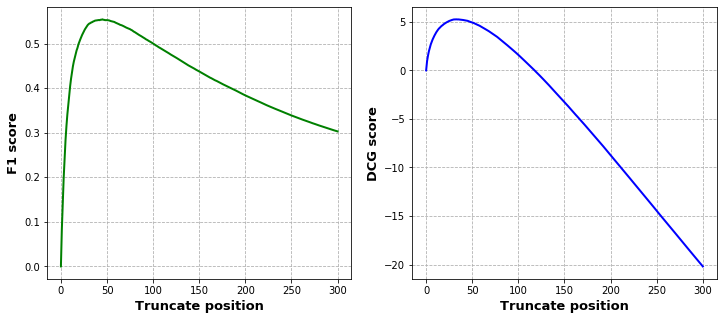

In [42]:
plt.figure(figsize=(16, 7))
x = np.arange(301)
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.grid(linestyle = "--")
plt.plot(x, f1_drmm_tks, color="green",linewidth=2.)
plt.xlabel('Truncate position', fontsize=13,fontweight='bold')
plt.ylabel('F1 score', fontsize=13,fontweight='bold')

plt.subplot(1, 2, 2)
plt.grid(linestyle = "--")
plt.plot(x, dcg_drmm_tks, color="blue",linewidth=2.)
plt.xlabel('Truncate position', fontsize=13,fontweight='bold')
plt.ylabel('DCG score', fontsize=13,fontweight='bold')

* 在bm25和drmm上，使用dcg指标的时候，需要控制惩罚项，否则会因为惩罚项太大，导致模型过分小心，甚至产生从0截断的情况，使得截断毫无意义；

* 在我们使用的所有数据集上，f1指标均可作为优化指标；